<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Basic Quantum Gates and Their Mathematical Definitions*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Rudy Raymond, Ali Javadi

## Quantum Gates 

Quantum gates on $q$ qubits can be regarded as unitary operations rotating a complex vector of dimension $2^q$, that corresponds to the quantum state. This tutorial is written to list elementary gates and their corresponding unitary matrices. Each gate is documented in [the OpenQASM language](https://github.com/QISKit/openqasm/blob/master/spec-human/qasm2.pdf). The gates are defined in [the file `qelib1.inc`](https://github.com/QISKit/openqasm/blob/master/examples/generic/qelib1.inc), and implemented in [the standard extension](https://github.com/QISKit/qiskit-sdk-py/tree/master/qiskit/extensions/standard). The gates can be divided into one-qubit gates and multi-qubit gates. 

Notice that in the IBM Quantum Experience, the order of qubits are represented from the most significant bit (MSB) on the left to the least significant bit (LSB) on the right. This is similar to bitstring representation on classical computers, and enables easy conversion from bitstrings to integers after measurements are performed. Thus, we write the tensor product of qubits $q_0$, $q_1$, and $q_2$ as $q_2 \otimes q_1 \otimes q_0$. The physics community often writes this in the opposite way, and care must be taken when working with these scenarios, as demonstrated in multi-qubit gates below.

We start with preparing the environment. 

In [96]:
# Checking the version of PYTHON; we only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')

# Useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

# Importing the QISKit
from qiskit import QuantumProgram
import Qconfig

# Import basic plot tools
from qiskit.tools.visualization import plot_histogram, plot_state

# Create the quantum program
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

# Creating registers
n_qubits = 3
qr = Q_program.create_quantum_register("qr", n_qubits)
cr = Q_program.create_classical_register("cr", n_qubits)

demoCircuit = Q_program.create_circuit('demoCircuit', [qr], [cr])

## One-Qubit Gates

The one-qubit gates available consist of Pauli $X, Y, Z$ gates, the Identity gate, primitives, and standard rotation gates. The primitives contain parametrized $u$ matrices (from one up to three parameters),  the Hadamard gate, the square-root of $Z$ (also referred as the $S$) gate and its conjugate, the square-root of $S$ (also referred as the $T$) gate and its conjugate. The standard rotation gates are those that define rotations around standard axis.  

### Pauli gates

#### $X$: bit-flip gate

The bit-flip gate $X$ is defined as:

$$
X \equiv u3(\pi, 0, \pi)  = 
-i
\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}
\equiv 
\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix},
$$
where in the hereafter $i = \sqrt{-1}$, and the symbol $\equiv$ denotes the equivalence up to the global phase. 

#### $Y$: bit- and phase-flip gate

The $Y$ gate is defined as:

$$
Y \equiv u3(\pi, \pi/2, \pi/2) = 
\begin{pmatrix}
0 & -i\\
i & 0
\end{pmatrix}
$$

#### $Z$: phase-flip gate

The $Z$ gate is defined as:

$$
Z = u1(\pi) = 
\begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}
$$

The pauli gates can be added as below.

In [97]:
pauli_demo = Q_program.create_circuit('pauli_demo', [qr], [cr])
pauli_demo.x(qr[0]) # applying x gate to the first qubit
pauli_demo.y(qr[1]) # applying y gate to the second qubit
pauli_demo.z(qr[2]) # applying z gate to the third qubit

We can illustrate the effect of each gate on each qubit by looking at how the state vectors get rotated on the Bloch sphere. We see 180 degree rotations of the initial $|0\rangle$ state (north pole) about the relavent axis in each case.

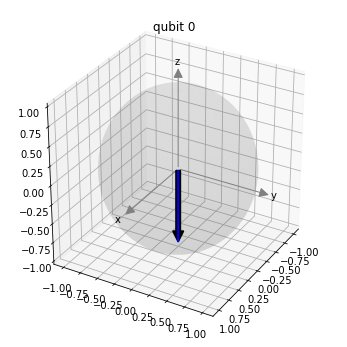

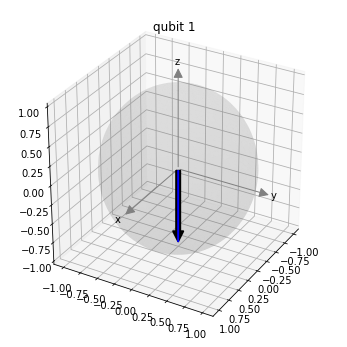

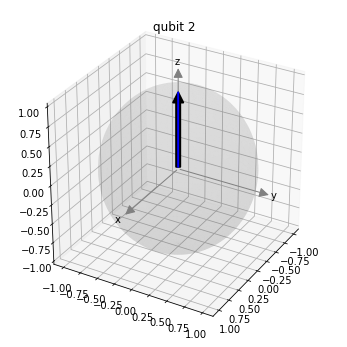

In [98]:
circuits = ['pauli_demo']
result = Q_program.execute(circuits, backend='local_unitary_simulator', shots=1024)
ground = np.zeros(2**n_qubits)
ground[0]=1.0
state_pauli = np.dot(result.get_data('pauli_demo')['unitary'],ground)
rho_pauli = np.outer(state_pauli, state_pauli.conj())
plot_state(rho_pauli,'bloch')

### Identity gate

The identity gate does nothing (but can add noise in the real device).

$$
I = 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}.
$$

It can be used in a circuit like below. Note the difference between results when running on an ideal simulator versus running on a real device.

In [118]:
import json
identity_demo = Q_program.create_circuit('identity_demo', [qr], [cr])

# applying iden gate to the first qubit
# barriers prevent them from being optimized away
identity_demo.iden(qr[0])
identity_demo.barrier(qr[0])
identity_demo.iden(qr[0])
identity_demo.barrier(qr[0])
identity_demo.iden(qr[0])
identity_demo.barrier(qr[0])
identity_demo.measure(qr[0], cr[0])

circuits = ['identity_demo']
result_ideal = Q_program.execute(circuits, backend='local_qasm_simulator', shots=1024)
result_noisy = Q_program.execute(circuits, backend='ibmqx2', shots=1024, timeout=300)

counts_ideal = result_ideal.get_counts('identity_demo')
counts_noisy = result_noisy.get_counts('identity_demo')
print("Counts from ideal simulation of identity gates: {}".format(
    json.dumps(counts_ideal)))
print("Counts from a real run of identity gates (i.e. wait): {}".format(
    json.dumps(counts_noisy)))

Counts from ideal simulation of identity gates: {"000": 1024}


### Primitives

The primitives contain parametrized $u$ matrices (from one up to three parameters),  the Hadamard gate, the square-root of $Z$ (also referred as the $S$) gate and its conjugate, the square-root of $S$ (also referred as the $T$) gate and its conjugate. 

#### u3 (or,  U gates with three parameters)

$u3(\theta, \phi, \lambda$ (or, $U(\theta, \phi, \lambda)$) gates are rotations of 1-qubit state whose mathematical definition are:

$$
u3(\theta, \phi, \lambda) =  
\begin{pmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2)\\
e^{i\phi}\sin(\theta/2) & e^{i(\phi + \lambda)}\cos(\theta/2)
\end{pmatrix}.
$$

Notice that the above unitaries are essentially equivalent to $e^{-i{(\phi + \lambda)}/{2}} u3(\theta, \phi, \lambda)$, as in Eq.(2) of the openqasm [here](https://github.com/QISKit/openqasm/blob/master/spec-human/qasm2.pdf). 

Here is the command to add such a $u3$ gate to a circuit.  

In [100]:
theta = pi/2.0   
phi = pi/3.0
lambd = pi/4.0
demoCircuit.u3(theta, phi, lambd, qr[0]) #applying a u3 gate to the first qubit 

#### u2 (or, U gates with two parameters)

$u2(\phi, \lambda)$ gates are rotations of 1-qubit state whose mathematical definitions are:

$$
u2(\phi, \lambda) \equiv u3(\pi/2, \phi, \lambda) = 
\frac{1}{\sqrt{2}} \begin{pmatrix}
1 & -e^{i\lambda} \\
e^{i\phi} & e^{i(\phi + \lambda)}
\end{pmatrix}.
$$

We can add a $u2$ gate to a circuit as follows.

In [101]:
phi = pi/3.0
lambd = pi/4.0
demoCircuit.u2(phi, lambd, qr[0]) #applying a u2 gate to the first qubit 

#### u1 (or, U gates with one parameter)

$u1(\lambda)$ gates are rotations of 1-qubit state whose mathematical definitions are:

$$
u1(\lambda) = u3(0, 0, \lambda) = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i \lambda}
\end{pmatrix}.
$$

We can add a $u1$ gate to a circuit as below.

In [102]:
lambd = pi/4.0
demoCircuit.u1(lambd, qr[0]) #applying a u1 gate to the first qubit 

#### Hadamard gate (Clifford)

$$
H = u2(0, \pi) =
1/\sqrt{2}
\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}
$$

#### $S$ (or, $\sqrt{Z}$ phase) gate (Clifford)

$$
S = u1(\pi/2) = 
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi/2}
\end{pmatrix}
$$

#### $S^{\dagger}$ (or, conjugate of $\sqrt{Z}$ phase) gate (Clifford)

$$
S^{\dagger} = u1(-\pi/2) = 
\begin{pmatrix}
1 & 0\\
0 & e^{-i\pi/2}
\end{pmatrix}
$$

The above Clifford gates can be added as below.

In [103]:
demoCircuit.h(qr[0]) #applying h gate to the first qubit
demoCircuit.s(qr[0]) #applying s gate to the first qubit
demoCircuit.sdg(qr[0]) #applying sdg gate to the first qubit

#### $T$ (or, $\sqrt{S}$ phase) gate ($C3$ gate)

$$
T = u1(pi/4) = 
\begin{pmatrix}
1 & 0\\
0 & e^{i \pi/4}
\end{pmatrix}
$$

#### $T^{\dagger}$ (or, conjugate of $\sqrt{S}$ phase) gate ($C3$ gate)

$$
T^{\dagger} = u1(-pi/4) = 
\begin{pmatrix}
1 & 0\\
0 & e^{-i \pi/4}
\end{pmatrix}
$$

They can be added as below.

In [104]:
demoCircuit.t(qr[0]) #applying t gate to the first qubit
demoCircuit.tdg(qr[0]) #applying tdg gate to the first qubit

### Standard Rotations

The standard rotation gates are those that define rotations around the standard axis. 

#### Rotation around X-axis

$$
R_x(\theta) = u3(\theta, -\pi/2, \pi/2) \equiv 
\begin{pmatrix}
\cos(\theta/2) & -i\sin(\theta/2)\\
-i\sin(\theta/2) & \cos(\theta/2).
\end{pmatrix}
$$

#### Rotation round Y-axis

$$
R_y(\theta) = u3(\theta, 0, 0) \equiv
\begin{pmatrix}
\cos(\theta/2) & \sin(\theta/2)\\
\sin(\theta/2) & \cos(\theta/2).
\end{pmatrix}
$$

#### Rotation around Z-axis

$$
R_z(\phi) = u1(\phi) = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i \phi}
\end{pmatrix}
$$

They can be added as below.

In [105]:
theta = pi/4
phi = pi/4
demoCircuit.rx(theta, qr[0]) #applying rotation around x-axis gate to the first qubit
demoCircuit.ry(theta, qr[0]) #applying rotation around y-axis gate to the first qubit
demoCircuit.rz(phi, qr[0]) #applying rotation around z-axis gate to the first qubit

## Multi-Qubit Gates

The standard multi-qubit gates consist of two-qubit gates and three-qubit gates. The two-qubit gates consist of the controlled Pauli gates, the controlled Hadamard gate, the controlled rotation gates, and the swap gate. The three-qubit gates consist of the Toffoli gate and the Fredkin gate. 

### Controlled Pauli Gates

#### Controlled-X (or, controlled-NOT) gate
The controlled-not gate flips the `target` qubit when the control qubit is in the state $|1\rangle$. If we take the MSB as the control qubit (e.g. `cx(q[1],q[0])`), then the matrix would look like

$$
C_X = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{pmatrix}. 
$$

However, when the LSB is the control qubit, (e.g. `cx(q[0],q[1])`), this gate is equivalent to the following matrix:

$$
C_X = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0
\end{pmatrix}. 
$$

#### Controlled $Y$ gate

Apply the $Y$ gate to the target qubit if the control qubit is $|1\rangle$, for when the MSB is the control

$$
C_Y = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & -i\\
0 & 0 & i & 0
\end{pmatrix},
$$

or when the LSB is the control

$$
C_Y = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & -i\\
0 & 0 & 1 & 0\\
0 & i & 0 & 0
\end{pmatrix}.
$$

#### Controlled $Z$ (or, controlled Phase) gate

Similarly, the controlled Z gate flips the phase of the target qubit if the control qubit is $1$. The matrix looks the same regardless of whether the MSB or LSB is the control qubit:

$$
C_Z = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & -1
\end{pmatrix}
$$

### Controlled Hadamard gate

Apply $H$ gate to the target qubit if the control qubit is $|1\rangle$. Below is the case where the control is the MSB qubit.

$$
C_H = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}\\
0 & 0 & \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}}
\end{pmatrix}
$$

In [106]:
demoCircuit.cx(qr[0], qr[1]) # applying cnot gate
demoCircuit.cy(qr[0], qr[1]) # controlled-y
demoCircuit.cz(qr[0], qr[1]) # controlled-z
demoCircuit.ch(qr[0], qr[1]) # controlled-h

### Controlled rotation gates

#### Controlled rotation around Z-axis

Perform rotation around Z-axis on the target qubit if the control qubit (here MSB) is $|1\rangle$.

$$
C_{Rz}(\lambda) = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & e^{-i\lambda/2} & 0\\
0 & 0 & 0 & e^{i\lambda/2}
\end{pmatrix}
$$

#### Controlled phase rotation

Perform $u1$ on the target qubit if the control qubit (here MSB) is $|1\rangle$.

$$
C_{u1}(\lambda) = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & e^{i\lambda}
\end{pmatrix}
$$

#### Controlled $U$ rotation

Perform controlled-$U$ rotation on the target qubit if the control qubit (here MSB) is $|1\rangle$. 

$$
C_{u3}(\theta, \phi, \lambda) \equiv 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & e^{-i(\phi+\lambda)/2}\cos(\theta/2) & -e^{-i(\phi-\lambda)/2}\sin(\theta/2)\\
0 & 0 & e^{i(\phi-\lambda)/2}\sin(\theta/2) & e^{i(\phi+\lambda)/2}\cos(\theta/2)
\end{pmatrix}.
$$

They can be added to the circuit as below.

In [107]:
demoCircuit.crz(lambd, qr[0], qr[1]) # controlled rotation around-Z
demoCircuit.cu1(lambd, qr[0], qr[1]) # controlled u1
demoCircuit.cu3(theta, phi, lambd, qr[0], qr[1]) # controlled u3

### Swap gate

The swap gate exchange the first and second qubits. 

$$
{SWAP} = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}.
$$

In [108]:
demoCircuit.swap(qr[0], qr[1])              # swapping the first and second qubits

### Toffoli gate ($C3$ gate)

The Toffoli gate flips the third qubit if the first two qubits (MSB) are both $|1\rangle$.

$$
C_{CX} = 
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{pmatrix}
$$

### Controlled swap gate (Fredkin Gate)

The controlled swap gate exchange the second and third qubits if the first qubit (MSB) is $|1\rangle$.

$$
C_{SWAP} = 
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{pmatrix}
$$

In [109]:
demoCircuit.ccx(qr[0], qr[1], qr[2])        # Toffoli gate
demoCircuit.cswap(qr[0], qr[1], qr[2])      # swapping the second and third qubits controlled by the first qubit

## Remark on the equivalence of gates up to the global phase 

In the above we see that the one-qubit $X$ gate is equivalent to the $u3(\pi, 0, \pi)$ gate up to the global phase, but the global phase can be tricky with controlled gates. For example, the $C_X$ gate (or, the control NOT gate) is not equivalent to the $C_{u3}(\pi, 0, \pi)$ gate. This is because:

$$
C_{u3}(\pi, 0, \pi) \equiv 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & -j\\
0 & 0 & -j & 0
\end{pmatrix} \neq 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{pmatrix} = C_X
$$ 

## State Initialization

When a qubit register is declared, the qubits start out initialized to the $|0\rangle$ or ground state. This is convenient in superconducting qubit technology, as well as many other technologies.

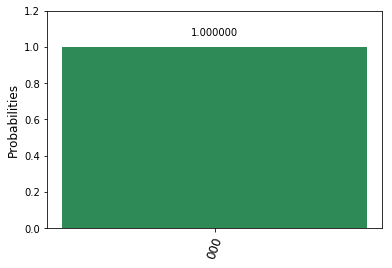

In [110]:
# A declared register starts out at the |00..0> state
initialize_circuit = Q_program.create_circuit('initialize_circuit', [qr], [cr])
initialize_circuit.measure(qr, cr)
circuits = ['initialize_circuit']
result = Q_program.execute(circuits, backend='local_qasm_simulator', shots=1024)
plot_histogram(result.get_counts('initialize_circuit'))

### Reset
It is also possible to `reset` qubits to the $|0\rangle$ state in the middle of computation. Note that `reset` is not a Gate operation, since it is irreversible.

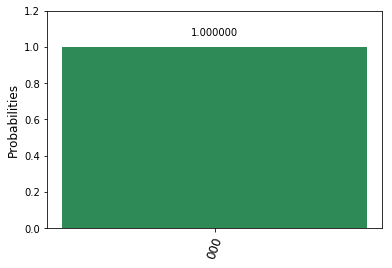

In [111]:
# A reset statement takes qubits back to |0>
reset_circuit = Q_program.create_circuit('reset_circuit', [qr], [cr])
reset_circuit.x(qr)
reset_circuit.h(qr)
reset_circuit.reset(qr)
reset_circuit.measure(qr, cr)
circuits = ['reset_circuit']
result = Q_program.execute(circuits, backend='local_qasm_simulator', shots=1024)
plot_histogram(result.get_counts('reset_circuit'))

### Arbitrary initialization
What if we want to initialize a qubit register to an arbitrary state? An arbitrary state for $n$ qubits may be specified by a vector of $2^n$ amplitudes, where the sum of amplitude-norms-squared equals 1. For example, the following three-qubit state can be prepared:

$$|\psi\rangle = \frac{i}{4}|000\rangle + \frac{1}{\sqrt{8}}|001\rangle + \frac{1+i}{4}|010\rangle + \frac{1+2i}{\sqrt{8}}|101\rangle + \frac{1}{4}|110\rangle$$

In [112]:
# Initializing a three-qubit quantum state
import math
desired_vector = [
    1 / math.sqrt(16) * complex(0, 1),
    1 / math.sqrt(8) * complex(1, 0),
    1 / math.sqrt(16) * complex(1, 1),
    0,
    0,
    1 / math.sqrt(8) * complex(1, 2),
    1 / math.sqrt(16) * complex(1, 0),
    0]
initialize_circuit_3q = Q_program.create_circuit('initialize_circuit_3q', [qr], [cr])
initialize_circuit_3q.initialize("init", desired_vector, [qr[0],qr[1],qr[2]])
initialize_circuit_3q.measure(qr, cr)
circuits = ['initialize_circuit_3q']
result = Q_program.execute(circuits, backend='local_qasm_simulator', shots=1024)

print("Desired probabilities...")
print(str(list(map(lambda x: format(abs(x * x), '.3f'), desired_vector))))

print("Probabilities from simulator...")
counts = result.get_counts("initialize_circuit_3q")
qubit_strings = [format(i, '0%sb' % n_qubits) for
                 i in range(2 ** n_qubits)]
print([format(counts.get(s, 0) / 1024, '.3f') for
       s in qubit_strings])

Desired probabilities...
['0.062', '0.125', '0.125', '0.000', '0.000', '0.625', '0.062', '0.000']
Probabilities from simulator...
['0.062', '0.138', '0.116', '0.000', '0.000', '0.625', '0.059', '0.000']


#### Further details:

How does the desired state get generated behind the scenes? There are multiple methods for doing this. QISKit uses a [method proposed by Shende et al](https://arxiv.org/abs/quant-ph/0406176). Here, the idea is to assume the quantum register to have started from our desired state, and construct a circuit that takes it to the $|00..0\rangle$ state. The initialization circuit is then the reverse of such circuit.

To take an arbitrary quantum state to the zero state in the computational basis, we perform an iterative procedure that disentangles qubits from the register one-by-one. We know that any arbitrary single-qubit state $|\rho\rangle$ can be taken to the $|0\rangle$ state using a $\phi$-degree rotation about the Z axis followed by a $\theta$-degree rotation about the Y axis:

$$R_y(-\theta)R_z(-\phi)|\rho\rangle = re^{it}|0\rangle$$

Since now we are dealing with $n$ qubits instead of just 1, we must factorize the state vector to separate the Least Significant Bit (LSB):

$$\begin{align*}
& |\psi\rangle = \alpha_{0_0}|00..00\rangle + \alpha_{0_1}|00..01\rangle + \alpha_{1_0}|00..10\rangle + \alpha_{1_1}|00..11\rangle + ... + \alpha_{(2^{n-1}-1)_0}|11..10\rangle + \alpha_{(2^{n-1}-1)_1}|11..11\rangle \\
&= |00..0\rangle (\alpha_{0_0}|0\rangle + \alpha_{0_1}|1\rangle) + |00..1\rangle (\alpha_{1_0}|0\rangle + \alpha_{1_1}|1\rangle) + ... + |11..1\rangle (\alpha_{(2^{n-1}-1)_0}(|0\rangle + \alpha_{(2^{n-1}-1)_1}|1\rangle) \\
&= |00..0\rangle|\rho_0\rangle + |00..1\rangle|\rho_1\rangle + ... + |11..1\rangle|\rho_{2^{n-1}-1}\rangle
\end{align*}$$

Now each of the single-qubit states $|\rho_0\rangle, ..., |\rho_{2^{n-1}-1}\rangle$ can be taken to $|0\rangle$ by finding appropriate $\phi$ and $\theta$ angles per the equation above. Doing this simultaneously on all states amounts to the following unitary, which disentangles the LSB:

$$U = \begin{pmatrix} 
R_{y}(-\theta_0)R_{z}(-\phi_0) & & & &\\  
& R_{y}(-\theta_1)R_{z}(-\phi_1) & & &\\
& . & & &\\
& & . & &\\
& & & & R_y(-\theta_{2^{n-1}-1})R_z(-\phi_{2^{n-1}-1})
\end{pmatrix} $$

Hence,

$$U|\psi\rangle = \begin{pmatrix} r_0e^{it_0}\\ r_1e^{it_1}\\ . \\ . \\ r_{2^{n-1}-1}e^{it_{2^{n-1}-1}} \end{pmatrix}\otimes|0\rangle$$


U can be implemented as a "quantum multiplexor" gate, since it is a block diagonal matrix. In the quantum multiplexor formalism, a block diagonal matrix of size $2^n \times 2^n$, and consisting of $2^s$ blocks, is equivalent to a multiplexor with $s$ select qubits and $n-s$ data qubits. Depending on the state of the select qubits, the corresponding blocks are applied to the data qubits. A multiplexor of this kind can be implemented after recursive decomposition to primitive gates of cx, rz and ry.

In [1]:
%run "../version.ipynb"

Package,Version
QISKit,0.4.8
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
